In [1]:
import os
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

import warnings

# Turn off all warnings
warnings.filterwarnings('ignore')

## Training and Validation Data

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.utils import to_categorical


# Path to the directory containing MIDI files
base_dir = './Composer_Dataset/NN_midi_files_extended/train'

# List of folders (composers) within the base directory
composer_folders = os.listdir(base_dir)

# Initialize lists to store extracted features and labels
x_training_data = []
y_training_data = []

# Encoder for composer labels
label_encoder = LabelEncoder()

# Function to apply pitch and tempo adjustments
def apply_transformations(midi_data):
    # Transpose by 2 semitones
    transposed_midi = midi_data
    for instrument in transposed_midi.instruments:
        for note in instrument.notes:
            note.pitch += 2
    
    # Increase tempo by 20%
    sped_up_midi = pretty_midi.PrettyMIDI()
    sped_up_midi.instruments = midi_data.instruments
    sped_up_midi.adjust_times(midi_data.get_onsets(), midi_data.get_onsets() * 1.2)
    
    return transposed_midi, sped_up_midi

# Loop through each composer folder
for composer_folder in composer_folders:
    composer_path = os.path.join(base_dir, composer_folder)
    
    # Check if the item in the base directory is a folder
    if os.path.isdir(composer_path):
        print(f"Loading MIDI files from {composer_folder}...")
        
        # Loop through each MIDI file in the composer folder
        for file_name in os.listdir(composer_path):
            file_path = os.path.join(composer_path, file_name)
            
            # Check if the item in the composer folder is a file and has a .mid or .midi extension
            if os.path.isfile(file_path) and (file_name.endswith('.mid') or file_name.endswith('.midi')):
                midi_data = pretty_midi.PrettyMIDI(file_path)
                
                # Apply transformations (pitch and tempo adjustments)
                transformed_midi_1, transformed_midi_2 = apply_transformations(midi_data)
                
                # Extract musical features (example: note events) from each transformed MIDI
                for transformed_midi in [transformed_midi_1, transformed_midi_2]:
                    note_events = []
                    for instrument in transformed_midi.instruments:
                        for note in instrument.notes:
                            note_events.append(note.pitch)
                    
                    # Normalize note_events using MinMaxScaler
                    scaler = MinMaxScaler(feature_range=(0, 1))
                    note_events_normalized = scaler.fit_transform(np.array(note_events).reshape(-1, 1))
                    
                    # Adjust sequence length based on your needs
                    sequence_length = 500  # Example sequence length
                    
                    # Pad sequences with zeros if shorter than sequence_length
                    if len(note_events_normalized) < sequence_length:
                        padded_sequence = np.zeros((sequence_length, 1))
                        padded_sequence[:len(note_events_normalized)] = note_events_normalized
                        x_training_data.append(padded_sequence.flatten())
                    else:
                        x_training_data.append(note_events_normalized[:sequence_length].flatten())
                    
                    y_training_data.append(composer_folder)  # Use folder name as label

# Convert lists to numpy arrays
x_training_data = np.array(x_training_data)
y_training_data = np.array(y_training_data)

# Encode composer labels
y_training_data_encoded = label_encoder.fit_transform(y_training_data)
num_classes = len(np.unique(y_training_data_encoded))
y_training_data_encoded_onehot = to_categorical(y_training_data_encoded, num_classes=num_classes)

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_training_data, y_training_data_encoded_onehot, test_size=0.2, random_state=42)


# Print shapes of extracted features and labels
print("Shapes:")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)


2024-08-06 17:01:24.178403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading MIDI files from mozart...
Loading MIDI files from chopin...
Loading MIDI files from handel...
Loading MIDI files from byrd...
Loading MIDI files from schumann...
Loading MIDI files from mendelssohn...
Loading MIDI files from hummel...
Loading MIDI files from bach...
Loading MIDI files from bartok...
Shapes:
x_train shape: (590, 500)
y_train shape: (590, 9)
x_val shape: (148, 500)
y_val shape: (148, 9)


## Test Data

In [5]:
# Path to the directory containing MIDI files
base_dir = './Composer_Dataset/NN_midi_files_extended/test'

# List of folders (composers) within the base directory
composer_folders = os.listdir(base_dir)

# Initialize lists to store extracted features and labels
x_test_data = []
y_test_data = []

# Encoder for composer labels
label_encoder = LabelEncoder()

# Loop through each composer folder
for composer_folder in composer_folders:
    composer_path = os.path.join(base_dir, composer_folder)
    
    # Check if the item in the base directory is a folder
    if os.path.isdir(composer_path):
        print(f"Loading MIDI files from {composer_folder}...")
        
        # Loop through each MIDI file in the composer folder
        for file_name in os.listdir(composer_path):
            file_path = os.path.join(composer_path, file_name)
            
            # Check if the item in the composer folder is a file and has a .mid or .midi extension
            if os.path.isfile(file_path) and (file_name.endswith('.mid')):
                midi_data = pretty_midi.PrettyMIDI(file_path)
                
                # Extract musical features (example: note events)
                note_events = []
                for instrument in midi_data.instruments:
                    for note in instrument.notes:
                        note_events.append(note.pitch)
                
                # Normalize note_events using MinMaxScaler
                scaler = MinMaxScaler(feature_range=(0, 1))
                note_events_normalized = scaler.fit_transform(np.array(note_events).reshape(-1, 1))
                
                # Adjust sequence length based on your needs
                sequence_length = 500  # Example sequence length
                
                # Pad sequences with zeros if shorter than sequence_length
                if len(note_events_normalized) < sequence_length:
                    padded_sequence = np.zeros((sequence_length, 1))
                    padded_sequence[:len(note_events_normalized)] = note_events_normalized
                    x_test_data.append(padded_sequence.flatten())
                else:
                    x_test_data.append(note_events_normalized[:sequence_length].flatten())
                    
                y_test_data.append(composer_folder)  # Use folder name as label

# Convert lists to numpy arrays
x_test_data = np.array(x_test_data)
y_test_data = np.array(y_test_data)

# Encode composer labels
y_test_data_encoded = label_encoder.fit_transform(y_test_data)
num_classes = len(np.unique(y_test_data_encoded))
y_test_data_encoded_onehot = to_categorical(y_test_data_encoded, num_classes=num_classes)

# Example: Print shapes of extracted features and labels
print("Shapes:")
print("x_test_data:", x_test_data.shape)
print("y_test_data_encoded:", y_test_data_encoded_onehot.shape)


Loading MIDI files from mozart...
Loading MIDI files from chopin...
Loading MIDI files from handel...
Loading MIDI files from byrd...
Loading MIDI files from schumann...
Loading MIDI files from mendelssohn...
Loading MIDI files from hummel...
Loading MIDI files from bach...
Loading MIDI files from bartok...
Shapes:
x_test_data: (35, 500)
y_test_data_encoded: (35, 9)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report

import random
random.seed(42)

## RNN + CNN

Epoch 1/50
19/19 [==============================] - 37s 2s/step - loss: 2.9151 - accuracy: 0.1203 - val_loss: 2.6859 - val_accuracy: 0.0743 - lr: 0.0010
Epoch 2/50
19/19 [==============================] - 29s 2s/step - loss: 2.3875 - accuracy: 0.2407 - val_loss: 2.2061 - val_accuracy: 0.2162 - lr: 0.0010
Epoch 3/50
19/19 [==============================] - 30s 2s/step - loss: 2.1377 - accuracy: 0.2678 - val_loss: 1.9861 - val_accuracy: 0.2905 - lr: 0.0010
Epoch 4/50
19/19 [==============================] - 29s 2s/step - loss: 1.9625 - accuracy: 0.2729 - val_loss: 1.9461 - val_accuracy: 0.2230 - lr: 0.0010
Epoch 5/50
19/19 [==============================] - 28s 1s/step - loss: 1.8984 - accuracy: 0.3136 - val_loss: 1.8620 - val_accuracy: 0.3041 - lr: 0.0010
Epoch 6/50
19/19 [==============================] - 28s 1s/step - loss: 1.8644 - accuracy: 0.3220 - val_loss: 1.8611 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 7/50
19/19 [==============================] - 33s 2s/step - loss: 1.8248 - a

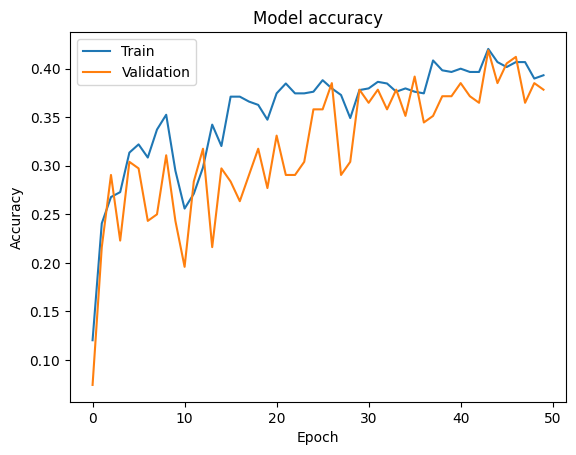

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM, Conv1D, MaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

import random
random.seed(42)

# Define model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001))),
    Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.001))),
    Dense(units=num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

# Evaluate model
loss, accuracy = model.evaluate(x_test_data, y_test_data_encoded_onehot)
print(f'Test accuracy: {accuracy}')

# Predict classes for test set
y_pred = model.predict(x_test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to original labels
y_test_labels = np.argmax(y_test_data_encoded_onehot, axis=1)

# Calculate precision, recall, and F1-score
report = classification_report(y_test_labels, y_pred_classes)
print("Classification Report:")
print(report)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
